# Dependencies

In [72]:
import pandas as pd
import requests
import json
import numpy as np
import matplotlib.pyplot as plt

import datetime as dt
import scipy.stats as sts
import scipy.ndimage as ndimage


from math import isnan
from matplotlib.animation import FuncAnimation
from matplotlib import animation, rc
from Resources.config import app_token

# Additional Depedencies which requires updating your environment

In [ ]:
import descartes
import geopandas as gpd
from geopandas import GeoDataFrame
from shapely.geometry import Point, Polygon

# Import Resources

In [73]:
## Source: Crimes - 2001 to present
## https://data.cityofchicago.org/Public-Safety/Crimes-2001-to-present/ijzp-q8t2
url_crime_data = "https://data.cityofchicago.org/resource/ijzp-q8t2.json"
date_filter="$WHERE=DATE BETWEEN '2014-01-01' AND '2018-12-31'"
crime_records_limit = 1000
## Total # 1344565
url_crime_data_with_filter = f"{url_crime_data}?{date_filter}&$limit={crime_records_limit}&$$app_token={app_token}"
crime_data_json = requests.get(url_crime_data_with_filter).json()
## Convert to pandas DataFrame
crime_data_df = pd.DataFrame.from_records(crime_data_json)
## drop extra columns. Optional
#crime_data_df = crime_data_df.drop(['x_coordinate','y_coordinate','latitude','longitude','location'],axis=1)

In [74]:
# Street Light Data Source from 2014-2018
street_light_reports = "Resources/Service_Requests_Street_Lights.csv" 

# Read Street Light Data and store into Pandas data frame, add ability to read special chrarters
street_light_reports_pd = pd.read_csv(street_light_reports,encoding= "ISO-8859-1")

In [75]:
# Community Area Names Data Source 
community_area_names = "Resources/CommAreas_20200108.csv" 

# Read Community Area Names Data and store into Pandas data frame, add ability to read special characters
community_area_names_pd = pd.read_csv(community_area_names,encoding= "ISO-8859-1")

In [76]:
# Pop Census Data Source 
pop_census_data = "Resources/Pop-Census-Data-by-Chicago-Community-Area-2017.csv" 

# Read Pop Census Data by Chicago Community and store into Pandas data frame.
pop_census_data_pd = pd.read_csv(pop_census_data)

# Data cleanup

In [77]:
#Data Cleanup - Rename Creation Date Column Because it Has Unnecessary Charaters in the CSV Field
street_light_reports_pd = street_light_reports_pd.rename(columns={'ÈÀCreation Date': 'Creation Date'})

# Add a Column for Year, Month, Day in Street Light Outage Data 
street_light_reports_pd['Year'] = pd.DatetimeIndex(street_light_reports_pd['Creation Date']).year
street_light_reports_pd['Month'] = pd.DatetimeIndex(street_light_reports_pd['Creation Date']).month
street_light_reports_pd['Day'] = pd.DatetimeIndex(street_light_reports_pd['Creation Date']).day

#Filter Street Light data for everything greater than 2013 and less than 2018
street_light_reports_pd = street_light_reports_pd.loc[(street_light_reports_pd['Year']>2013) & (street_light_reports_pd['Year']<2019)]
street_light_reports_pd

## Delete extra columns
#del street_light_reports_pd["Ward", "Police District"]
street_light_reports_pd = street_light_reports_pd.drop(["Ward", "Police District"], axis=1)
street_light_reports_pd.head()

,Creation Date,Status,Completion Date,Service Request Number,Type of Service Request,Street Address,ZIP Code,X Coordinate,Y Coordinate,Community Area,Latitude,Longitude,Location,Year,Month,Day
0,8/2/2017,Completed,8/4/2017,17-05118301,Street Lights - All/Out,3200 W AUGUSTA BLVD,60651.0,1154852.812,1906479.787,23.0,41.899195,-87.706674,"(41.899195401337, -87.706674456727)",2017,8,2
1,8/3/2017,Completed,8/4/2017,17-05149048,Street Lights - All/Out,11633 S PRINCETON AVE,60628.0,1176368.398,1827790.516,53.0,41.682806,-87.630013,"(41.682805663082, -87.630013185779)",2017,8,3
2,8/2/2017,Completed,8/4/2017,17-05136485,Street Lights - All/Out,300 W 105TH PL,60628.0,1176096.554,1834970.868,49.0,41.702516,-87.630794,"(41.702515706043, -87.630793923998)",2017,8,2
3,8/3/2017,Completed,8/4/2017,17-05143874,Street Lights - All/Out,1250 S THROOP ST,60608.0,1167901.851,1894431.139,28.0,41.865861,-87.659093,"(41.865861460198, -87.659093452162)",2017,8,3
4,8/3/2017,Completed,8/4/2017,17-05149056,Street Lights - All/Out,1600 N KEDZIE AVE,60647.0,1154745.892,1910458.441,23.0,41.910115,-87.706960,"(41.91011532918, -87.706960465932)",2017,8,3


## Question 1 - Which Chicago neighborhoods have the most street light outages reported between 2014-2018?

In [78]:
#Create Community Area Count Variable
community_area_counts = street_light_reports_pd.groupby(["Community Area"])["Creation Date"].nunique()

#Display Summary of Community Area Counts in Data Frame
community_area_summary_table = pd.DataFrame({"Total Street Light Outage Reportings": community_area_counts})
community_area_summary_table

,Total Street Light Outage Reportings
Community Area,
0.0,192
1.0,323
2.0,637
3.0,363
4.0,476
...,...
73.0,937
74.0,520
75.0,817


In [79]:
#Display Summary of Community Area Names and Corresposonding Number in Data Frame
community_area_names=community_area_names_pd[['COMMUNITY','AREA_NUMBE']]
community_area_names

,COMMUNITY,AREA_NUMBE
0,DOUGLAS,35
1,OAKLAND,36
2,FULLER PARK,37
3,GRAND BOULEVARD,38
4,KENWOOD,39
...,...,...
72,MOUNT GREENWOOD,74
73,MORGAN PARK,75
74,OHARE,76
75,EDGEWATER,77


In [80]:
# Merge Dataframes to get Street Light Outage Reports and Community Names in One Dataframe
community_data_merge = pd.merge(community_area_summary_table,community_area_names,left_on='Community Area', right_on='AREA_NUMBE', how="right")

#Sort Merged Dataframe by Highest Street Light Outages to Find Community With Highest Street Outages
community_sort = community_data_merge.sort_values(by='Total Street Light Outage Reportings', ascending=False)

# Display the Top 10 Neighborhoods With Most Street Light Outages 2014 to 2018
community_sort.head(10)

,Total Street Light Outage Reportings,COMMUNITY,AREA_NUMBE
24,1207,AUSTIN,25
48,1092,ROSELAND,49
23,1092,WEST TOWN,24
69,1085,ASHBURN,70
70,1071,AUBURN GRESHAM,71
27,977,NEAR WEST SIDE,28
65,957,CHICAGO LAWN,66
22,951,HUMBOLDT PARK,23
72,937,WASHINGTON HEIGHTS,73
42,924,SOUTH SHORE,43


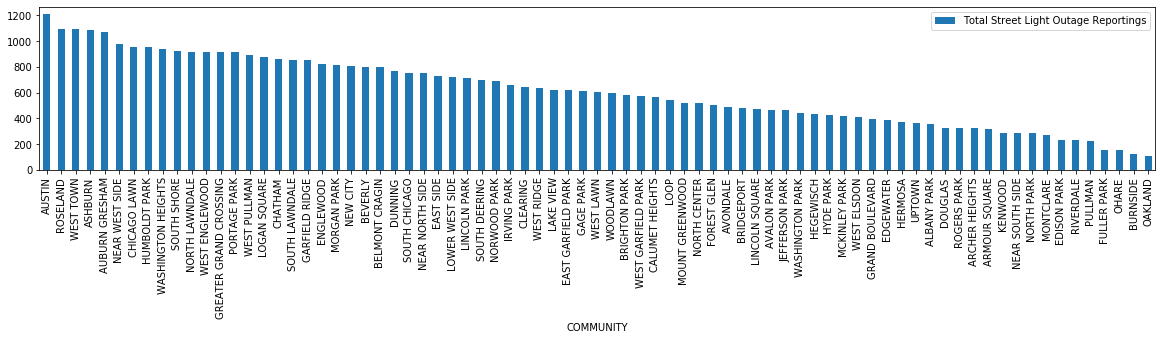

In [81]:
#Display Bar Chart to compare community area street light outages between 2014-2018
community_chart = community_sort.plot.bar(y='Total Street Light Outage Reportings', x='COMMUNITY', rot=90, figsize=(20,3))
plt.savefig("Charts/Street_Light_Outage_by_Community")

In [82]:
# Filter Street Light Outage Totals by Year 
year_2014 = street_light_reports_pd[street_light_reports_pd['Year']==2014]
year_2015 = street_light_reports_pd[street_light_reports_pd['Year']==2015]
year_2016 = street_light_reports_pd[street_light_reports_pd['Year']==2016]
year_2017 = street_light_reports_pd[street_light_reports_pd['Year']==2017]
year_2018 = street_light_reports_pd[street_light_reports_pd['Year']==2018]

In [83]:
#Filter Street Light Counts by 2014 
counts_by_year_2014 = year_2014.groupby(["Community Area","Year"])["Creation Date"].nunique()

#Display 2014 Summary of Street Light Outages by Year in Data Frame
counts_by_year_2014_summary_table = pd.DataFrame({ "# of Outages in 2014": counts_by_year_2014})

#Sort Merged Dataframe by Highest Street Light Outages to Find Community With Highest Street Outages
community_sort_2014 = counts_by_year_2014_summary_table.sort_values(by='# of Outages in 2014', ascending=False)

# Display the Top 5 Neighborhoods With Most Street Light Outages in 2014
community_sort_2014.head(5)

,,# of Outages in 2014
Community Area,Year,
49.0,2014,255
25.0,2014,254
71.0,2014,237
73.0,2014,222
15.0,2014,219


In [84]:
#Filter Street Light Counts by 2015 
counts_by_year_2015 = year_2015.groupby(["Community Area","Year"])["Creation Date"].nunique()

#Display 2015 Summary of Street Light Outages by Year in Data Frame
counts_by_year_2015_summary_table = pd.DataFrame({"# of Outages in 2015": counts_by_year_2015})

#Sort Merged Dataframe by Highest Street Light Outages to Find Community With Highest Street Outages
community_sort_2015 = counts_by_year_2015_summary_table.sort_values(by='# of Outages in 2015', ascending=False)

# Display the Top 5 Neighborhoods With Most Street Light Outages in 2015
community_sort_2015.head(5)

,,# of Outages in 2015
Community Area,Year,
25.0,2015,240
70.0,2015,236
49.0,2015,223
71.0,2015,214
43.0,2015,210


In [85]:
#Filter Street Light Counts by 2016 
counts_by_year_2016 = year_2016.groupby(["Community Area","Year"])["Creation Date"].nunique()

#Display 2014 Summary of Street Light Outages by Year in Data Frame
counts_by_year_2016_summary_table = pd.DataFrame({"# of Outages in 2016": counts_by_year_2016})

#Sort Merged Dataframe by Highest Street Light Outages to Find Community With Highest Street Outages
community_sort_2016 = counts_by_year_2016_summary_table.sort_values(by='# of Outages in 2016', ascending=False)

# Display the Top 5 Neighborhoods With Most Street Light Outages in 2016
community_sort_2016.head(5)

,,# of Outages in 2016
Community Area,Year,
24.0,2016,243
25.0,2016,228
71.0,2016,224
70.0,2016,221
49.0,2016,220


In [86]:
#Filter Street Light Counts by 2017 
counts_by_year_2017 = year_2017.groupby(["Community Area","Year"])["Creation Date"].nunique()

#Display 2017 Summary of Street Light Outages by Year in Data Frame
counts_by_year_2017_summary_table = pd.DataFrame({"# of Outages in 2017": counts_by_year_2017})

#Sort Merged Dataframe by Highest Street Light Outages to Find Community With Highest Street Outages
community_sort_2017 = counts_by_year_2017_summary_table.sort_values(by='# of Outages in 2017', ascending=False)

# Display the Top 5 Neighborhoods With Most Street Light Outages in 2017
community_sort_2017.head(5)

,,# of Outages in 2017
Community Area,Year,
25.0,2017,252
24.0,2017,228
70.0,2017,223
23.0,2017,205
30.0,2017,198


In [87]:
#Filter Street Light Counts by 2018
counts_by_year_2018 = year_2018.groupby(["Community Area","Year"])["Creation Date"].nunique()

#Display 2018 Summary of Street Light Outages by Year in Data Frame
counts_by_year_2018_summary_table = pd.DataFrame({"# of Outages in 2018": counts_by_year_2018})

#Sort Merged Dataframe by Highest Street Light Outages to Find Community With Highest Street Outages
community_sort_2018 = counts_by_year_2018_summary_table.sort_values(by='# of Outages in 2018', ascending=False)

# Display the Top 10 Neighborhoods With Most Street Light Outages in 2018
community_sort_2018.head(5)

,,# of Outages in 2018
Community Area,Year,
25.0,2018,233
24.0,2018,221
49.0,2018,204
71.0,2018,203
28.0,2018,201


## Question 2 - What address has the most street light outage reports? Which year had the most street light outage reports?

## Question 3 - Average time it takes for outages to get fixed per neighborhood?

In [108]:
## Join 2 tables to display community names.
service_requests_by_community = pd.merge(street_light_reports_pd, community_area_names_pd, left_on='Community Area', right_on='AREA_NUMBE', how='left')
## Drop extra column
service_requests_by_community = service_requests_by_community.drop(["Latitude","Longitude","Location","AREA_NUMBE","the_geom","PERIMETER","AREA","COMAREA_","COMAREA_ID","AREA_NUM_1","SHAPE_AREA","SHAPE_LEN"], axis=1)
## Calculate service requests resolution time after setting completion_date to current date if N/A
service_requests_by_community['Resolution Time(days)'] = (pd.to_datetime(service_requests_by_community['Completion Date'].fillna(pd.datetime.now().date())) - pd.to_datetime(service_requests_by_community['Creation Date'])).dt.days
service_requests_by_community.head()

,Creation Date,Status,Completion Date,Service Request Number,Type of Service Request,Street Address,ZIP Code,X Coordinate,Y Coordinate,Community Area,Year,Month,Day,COMMUNITY,Resolution Time(days)
0,8/2/2017,Completed,8/4/2017,17-05118301,Street Lights - All/Out,3200 W AUGUSTA BLVD,60651.0,1154852.812,1906479.787,23.0,2017,8,2,HUMBOLDT PARK,2
1,8/3/2017,Completed,8/4/2017,17-05149048,Street Lights - All/Out,11633 S PRINCETON AVE,60628.0,1176368.398,1827790.516,53.0,2017,8,3,WEST PULLMAN,1
2,8/2/2017,Completed,8/4/2017,17-05136485,Street Lights - All/Out,300 W 105TH PL,60628.0,1176096.554,1834970.868,49.0,2017,8,2,ROSELAND,2
3,8/3/2017,Completed,8/4/2017,17-05143874,Street Lights - All/Out,1250 S THROOP ST,60608.0,1167901.851,1894431.139,28.0,2017,8,3,NEAR WEST SIDE,1
4,8/3/2017,Completed,8/4/2017,17-05149056,Street Lights - All/Out,1600 N KEDZIE AVE,60647.0,1154745.892,1910458.441,23.0,2017,8,3,HUMBOLDT PARK,1


In [109]:
## Filter out rows where community_area = 0 OR service_request_number is duplicate 
service_requests_by_community = service_requests_by_community.loc[(service_requests_by_community['Community Area']!=0)]
service_requests_by_community = service_requests_by_community.drop_duplicates(subset="Service Request Number")
service_requests_by_community.head()

,Creation Date,Status,Completion Date,Service Request Number,Type of Service Request,Street Address,ZIP Code,X Coordinate,Y Coordinate,Community Area,Year,Month,Day,COMMUNITY,Resolution Time(days)
0,8/2/2017,Completed,8/4/2017,17-05118301,Street Lights - All/Out,3200 W AUGUSTA BLVD,60651.0,1154852.812,1906479.787,23.0,2017,8,2,HUMBOLDT PARK,2
1,8/3/2017,Completed,8/4/2017,17-05149048,Street Lights - All/Out,11633 S PRINCETON AVE,60628.0,1176368.398,1827790.516,53.0,2017,8,3,WEST PULLMAN,1
2,8/2/2017,Completed,8/4/2017,17-05136485,Street Lights - All/Out,300 W 105TH PL,60628.0,1176096.554,1834970.868,49.0,2017,8,2,ROSELAND,2
3,8/3/2017,Completed,8/4/2017,17-05143874,Street Lights - All/Out,1250 S THROOP ST,60608.0,1167901.851,1894431.139,28.0,2017,8,3,NEAR WEST SIDE,1
4,8/3/2017,Completed,8/4/2017,17-05149056,Street Lights - All/Out,1600 N KEDZIE AVE,60647.0,1154745.892,1910458.441,23.0,2017,8,3,HUMBOLDT PARK,1


In [113]:
service_requests_by_community_average_time = service_requests_by_community.groupby(["COMMUNITY","Year"])["Resolution Time(days)"].mean()
service_requests_by_community_average_time.sort_values(ascending=False)
service_requests_by_community_average_time = pd.DataFrame(service_requests_by_community_average_time).reset_index()
service_requests_by_community_average_time

In [116]:
# Filtered by year
service_requests_by_community_average_time_2014 = service_requests_by_community_average_time.loc[service_requests_by_community_average_time["Year"] == 2014].sort_values(by="Resolution Time(days)",ascending=False)
service_requests_by_community_average_time_2015 = service_requests_by_community_average_time.loc[service_requests_by_community_average_time["Year"] == 2015].sort_values(by="Resolution Time(days)",ascending=False)
service_requests_by_community_average_time_2016 = service_requests_by_community_average_time.loc[service_requests_by_community_average_time["Year"] == 2016].sort_values(by="Resolution Time(days)",ascending=False)
service_requests_by_community_average_time_2017 = service_requests_by_community_average_time.loc[service_requests_by_community_average_time["Year"] == 2017].sort_values(by="Resolution Time(days)",ascending=False)
service_requests_by_community_average_time_2018 = service_requests_by_community_average_time.loc[service_requests_by_community_average_time["Year"] == 2018].sort_values(by="Resolution Time(days)",ascending=False)

### Visuals for

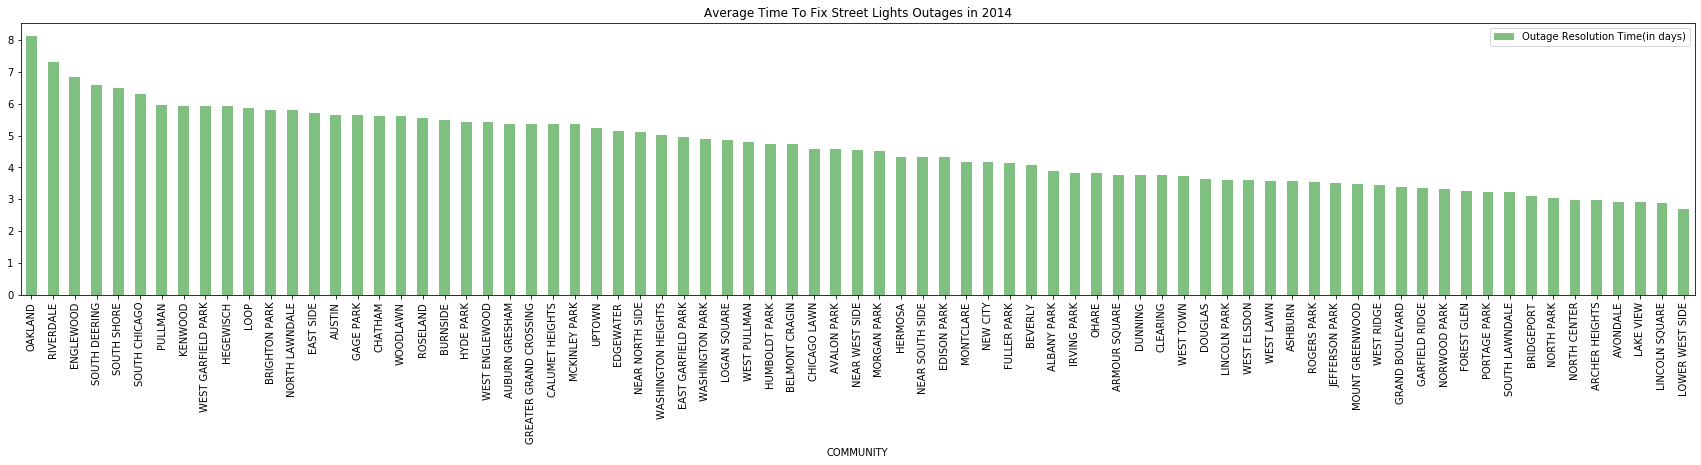

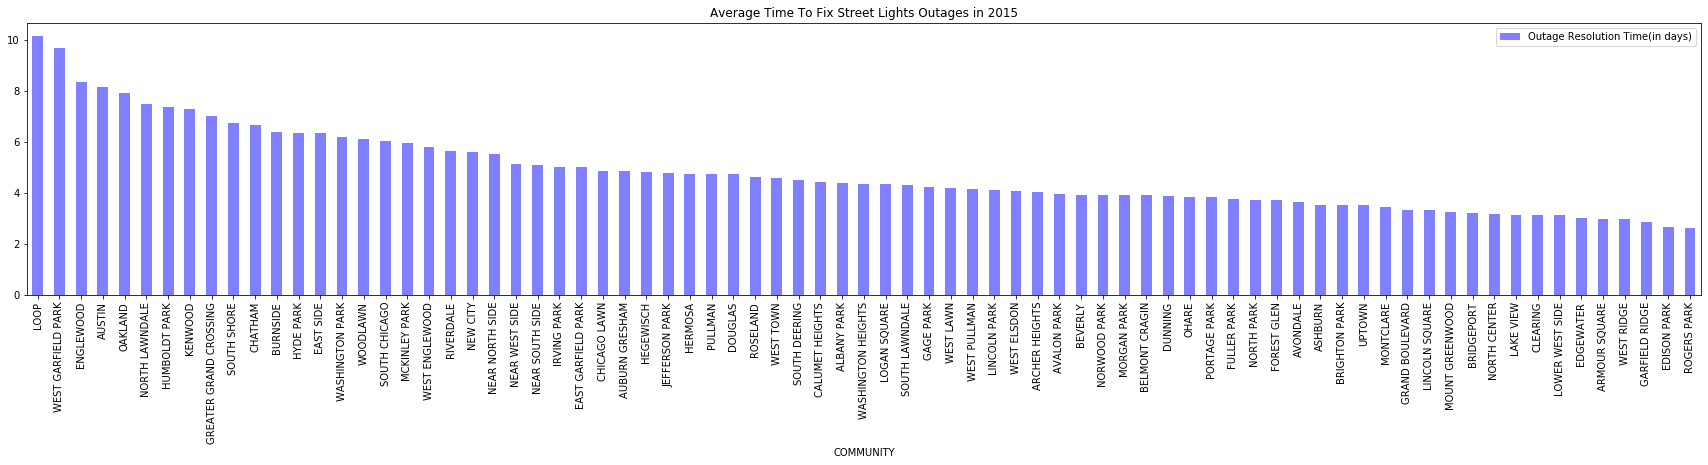

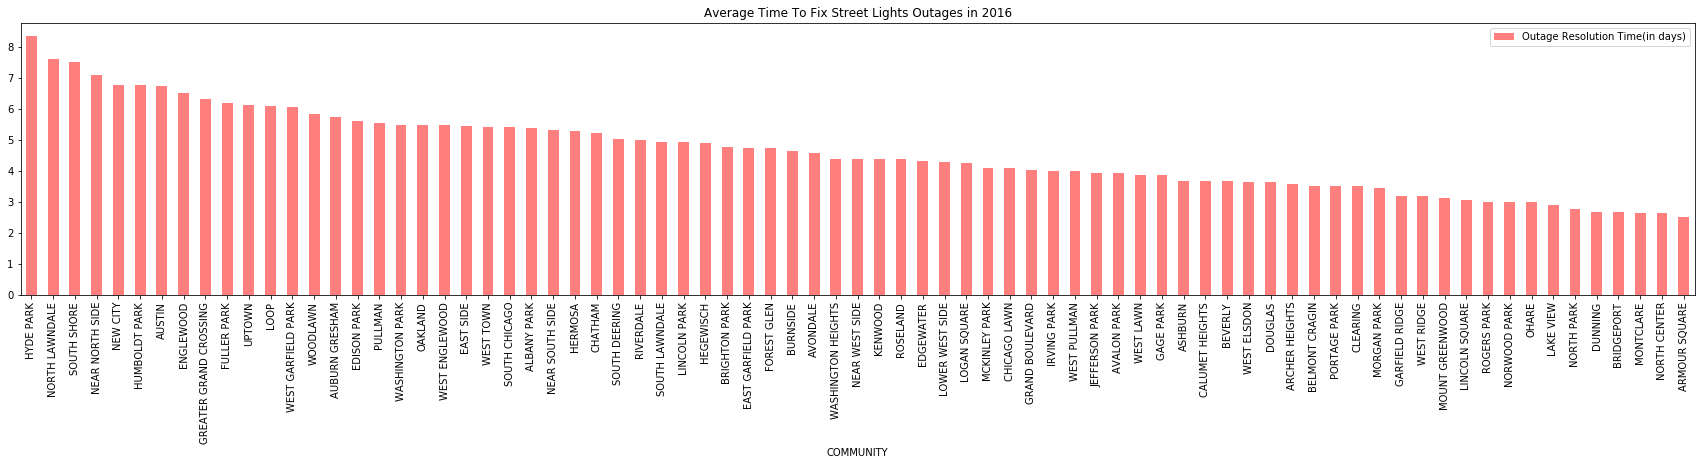

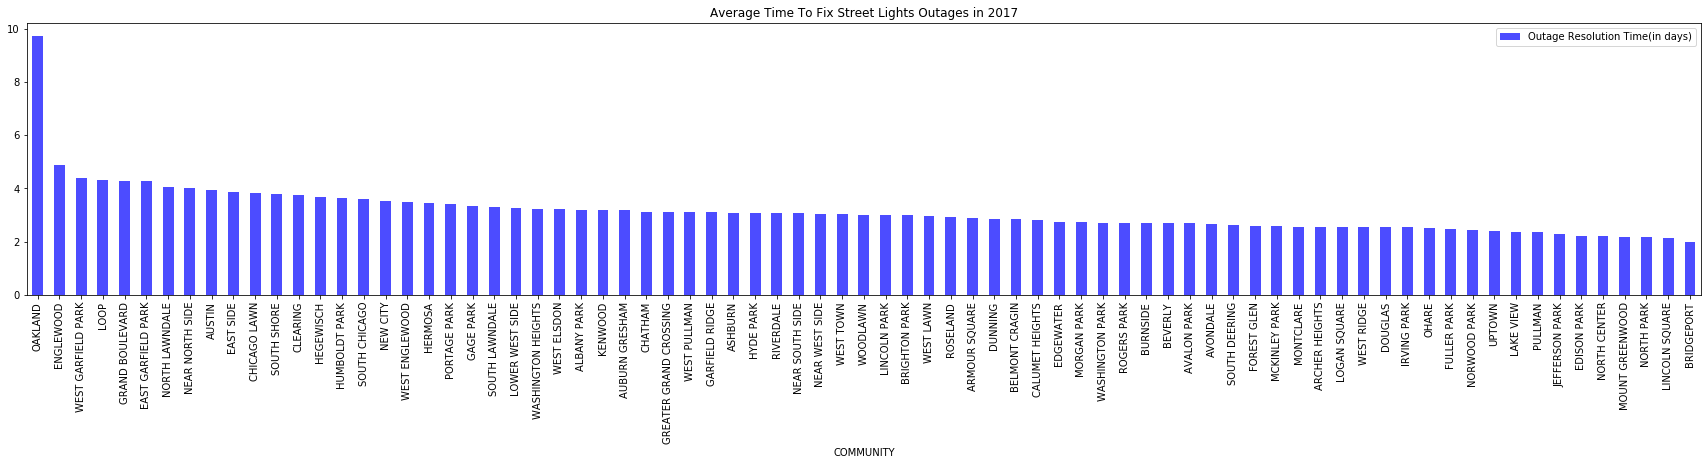

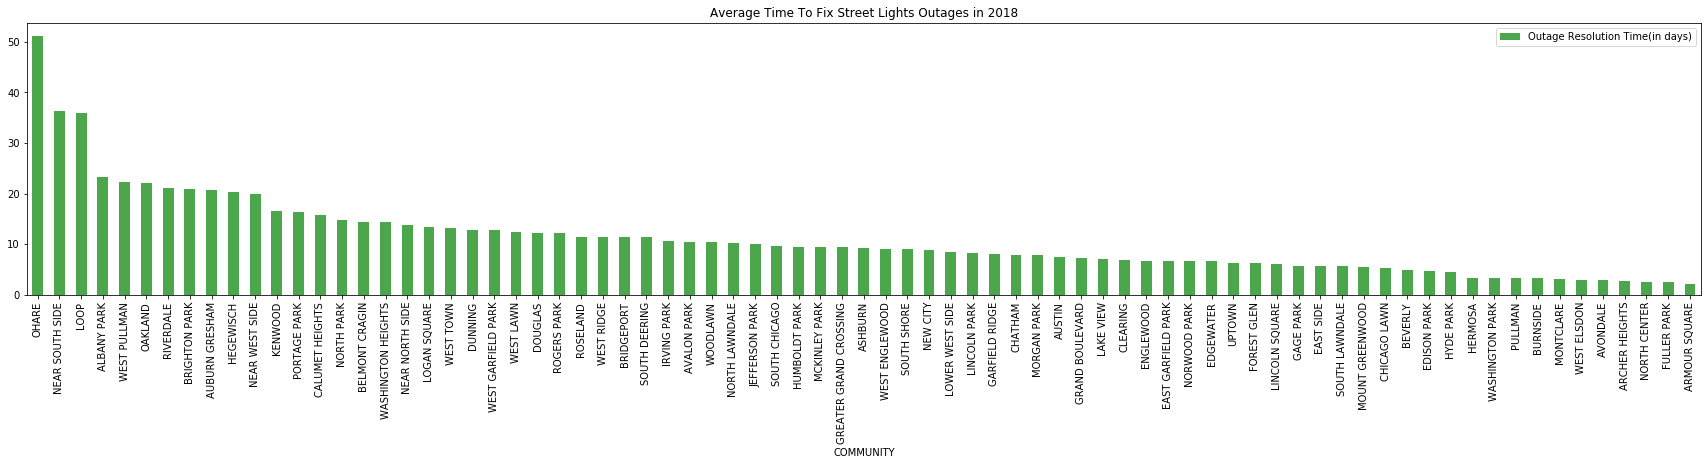

In [119]:
average_time_chart_2014 = service_requests_by_community_average_time_2014.plot.bar(y='Resolution Time(days)', x='COMMUNITY', label="Outage Resolution Time(in days)",alpha=0.5, align="center", color="green", rot=90, figsize=(30,5), title="Average Time To Fix Street Lights Outages in 2014")
plt.savefig("Charts/average_time_chart_2014.png", bbox_inches = 'tight')
average_time_chart_2015 = service_requests_by_community_average_time_2015.plot.bar(y='Resolution Time(days)', x='COMMUNITY', label="Outage Resolution Time(in days)", alpha=0.5, align="center", color="blue", rot=90, figsize=(30,5), title="Average Time To Fix Street Lights Outages in 2015")
plt.savefig("Charts/average_time_chart_2015.png", bbox_inches = 'tight')
average_time_chart_2016 = service_requests_by_community_average_time_2016.plot.bar(y='Resolution Time(days)', x='COMMUNITY', label="Outage Resolution Time(in days)", alpha=0.5, align="center", color="red", rot=90, figsize=(30,5), title="Average Time To Fix Street Lights Outages in 2016")
plt.savefig("Charts/average_time_chart_2016.png", bbox_inches = 'tight')
average_time_chart_2017 = service_requests_by_community_average_time_2017.plot.bar(y='Resolution Time(days)', x='COMMUNITY', label="Outage Resolution Time(in days)", alpha=0.7, align="center", color="blue", rot=90, figsize=(30,5), title="Average Time To Fix Street Lights Outages in 2017")
plt.savefig("Charts/average_time_chart_2017.png", bbox_inches = 'tight')
average_time_chart_2018 = service_requests_by_community_average_time_2018.plot.bar(y='Resolution Time(days)', x='COMMUNITY', label="Outage Resolution Time(in days)", alpha=0.7, align="center", color="green", rot=90, figsize=(30,5), title="Average Time To Fix Street Lights Outages in 2018")
plt.savefig("Charts/average_time_chart_2018.png", bbox_inches = 'tight')

## Question 4 - What are the crime rates/reports in neighborhoods with street light outages?